In [12]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


from forward import ForwardProcess
from dataset import DMDataset
from utils import transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

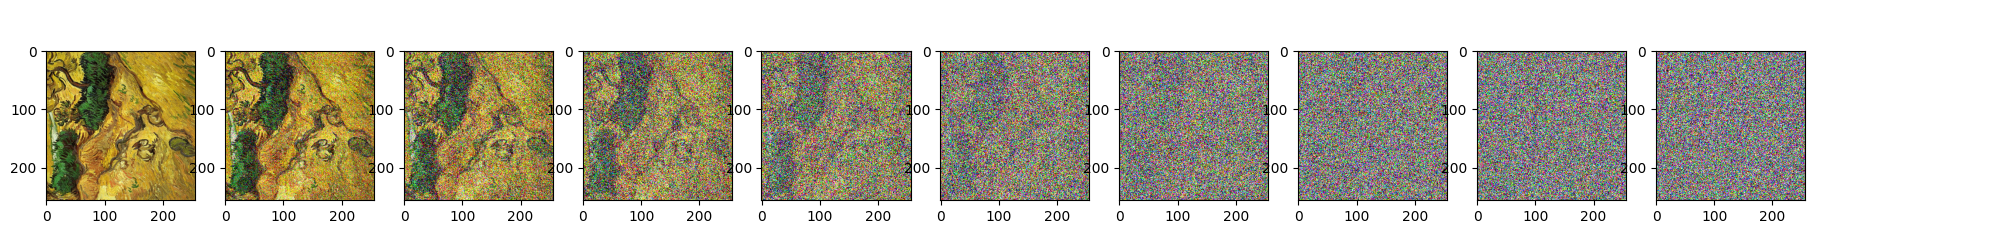

In [29]:
def main(arg_dict):
    """
    Params:
        arg_dict: the hyper-parameters
    """
    # create the transform mode
    transforms = transform()

    # load the dataset
    train_dataset = DMDataset(arg_dict['train'], transform=transforms)
    test_dataset = DMDataset(arg_dict['test'], transform=transforms)
    # create the dataloader
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=arg_dict['batch_size'],
        pin_memory=True,
        shuffle=True
    )
    # device
    device = arg_dict['device']

    # create the ForwardProcess Model
    fp = ForwardProcess(arg_dict['T']).to(device)
    
    image = next(iter(train_loader))[0].to(device)

    plt.figure(figsize=(25, 3))
    plt.axis('off')
    num_images = 10
    step_size = int(arg_dict['T'] / num_images)

    for t in range(0, arg_dict['T'], step_size):
        plt.subplot(1, num_images+1, int(t/step_size)+1)
        img, noise = fp.forward_diffusion_sample(image, t)
        # rebuild the image
        img = img * 0.5 + 0.5
        img = img.transpose(0, 2)
        plt.imshow(img)
    plt.show()


arg_dict = {
    "train": './data/train',
    "test": './data/test',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 16,
    "T": 1000  # timesteps
}

main(arg_dict)

In [1]:
import torch
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0] # 16
    out = vals.gather(-1, t.cpu())
    print(out)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)  # (16, 3, 64, 64)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x_0 = torch.rand(size=(16, 3, 64, 64))
t = torch.randint(0, T, (16,), device=device).long()

x_noisy, noise = forward_diffusion_sample(x_0, t, device)
print(x_noisy.shape)
print(noise.shape)

tensor([0.3032, 0.3426, 0.6171, 0.4354, 0.9724, 0.3633, 0.7769, 0.9912, 0.6972,
        0.6903, 0.9999, 0.2214, 0.5471, 0.7833, 0.9968, 0.5575])
tensor([0.9529, 0.9395, 0.7869, 0.9003, 0.2333, 0.9317, 0.6296, 0.1320, 0.7169,
        0.7235, 0.0100, 0.9752, 0.8371, 0.6217, 0.0805, 0.8302])
torch.Size([16, 3, 64, 64])
torch.Size([16, 3, 64, 64])
